### E10S Experiment Beta: Top hang stacks

[Bug 1222972](https://bugzilla.mozilla.org/show_bug.cgi?id=1222972)

This analysis compares e10s and non-e10s hang stacks and their frequencies.

In [1]:
import ujson as json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.plotly as py
import IPython
import functools

from __future__ import division
from moztelemetry.spark import get_pings, get_one_ping_per_client, get_pings_properties
from montecarlino import grouped_permutation_test

%pylab inline
IPython.core.pylabtools.figsize(16, 7)

Unable to parse whitelist (/home/hadoop/anaconda2/lib/python2.7/site-packages/moztelemetry/bucket-whitelist.json). Assuming all histograms are acceptable.
Populating the interactive namespace from numpy and matplotlib


In [2]:
sc.defaultParallelism

16

#### Get e10s and non-e10s partitions

In [3]:
dataset = sqlContext.read.load("s3://telemetry-parquet/e10s-experiment/e10s-enabled-beta-20151214@experiments.mozilla.org/generationDate=20160106", "parquet")

Only consider builds with [bug 1234618](https://bugzilla.mozilla.org/show_bug.cgi?id=1234618) BHR fix:

In [4]:
dataset = dataset.filter(dataset.buildId >= '20151228134903')

How many pings do we have in each branch?

In [5]:
dataset.filter(dataset["experimentBranch"] == "experiment").count()

60146

In [6]:
dataset.filter(dataset["experimentBranch"] == "control").count()

61770

Transform Dataframe to RDD of pings

In [7]:
def row_2_ping(row):
    ping = {"payload": {"threadHangStats": json.loads(row.threadHangStats)},
            "e10s": True if row.experimentBranch == "experiment" else False}
    return ping

In [8]:
subset = dataset.rdd.map(row_2_ping)

### Thread activity

In [9]:
def chi2_distance(xs, ys, eps = 1e-10, normalize = True):
    histA = xs.sum(axis=0)
    histB = ys.sum(axis=0)
    
    if normalize:
        histA = histA/histA.sum()
        histB = histB/histB.sum()
    
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(histA, histB)])

    return d

def ignore_below_(min_limit, histogram):
    histogram = histogram.ix[65:].set_value(0, histogram.ix[0: 64].sum()).sort_index()
    histogram = histogram.ix[min_limit:]
    return histogram

def ignore_below(histograms, min_limit=0):
    return histograms.map(functools.partial(ignore_below_, min_limit))

def normalize(histograms):
    return histograms.map(lambda h: h/max(h.sum(), 1))

def compare_histogram(histogram, e10s, none10s):
    pvalue = grouped_permutation_test(chi2_distance, [e10s, none10s], num_samples=100)
    
    eTotal = e10s.sum()
    nTotal = none10s.sum()
        
    eTotal = 100*eTotal/eTotal.sum()
    nTotal = 100*nTotal/nTotal.sum()
        
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.3)
        
    ax = fig.add_subplot(1, 1, 1)
    ax2 = ax.twinx()
    width = 0.4
    ylim = max(eTotal.max(), nTotal.max())
        
    eTotal.plot(kind="bar", alpha=0.5, color="green", label="e10s", ax=ax, width=width, position=0, ylim=(0, ylim + 1))
    nTotal.plot(kind="bar", alpha=0.5, color="blue", label="non e10s", ax=ax2, width=width, position=1, grid=False, ylim=ax.get_ylim())
        
    ax.legend(ax.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0],
              ["e10s ({} samples".format(len(e10s)), "non e10s ({} samples)".format(len(none10s))])

    plt.title(histogram)
    plt.xlabel(histogram)
    plt.ylabel("Frequency %")
    plt.show()
        
    print "The probability that the distributions for {} are differing by chance is {:.2f}.".format(histogram, pvalue)

def compare_histograms(histogram, e10s, none10s, min_limit):
    e10s = ignore_below(e10s, min_limit)
    none10s = ignore_below(none10s, min_limit)
    compare_histogram(histogram + " (normalized)", normalize(e10s), normalize(none10s))
    compare_histogram(histogram + " (absolute)", e10s, none10s)

In [10]:
# Manually massage the thread activity histogram into payload/histograms so that
# get_pings_properties will treat is a histogram.
def get_activity(ping):
    for thread in ping["payload"]["threadHangStats"]:
        if thread["name"] != "Gecko":
            continue

        values = {str(int(k) + 1): v for k, v in thread["activity"]["values"].iteritems()}                                        
        yield {"e10s": ping["e10s"], "payload": {"histograms": {"GECKO_THREAD_ACTIVITY_MS": {"values": values}}}}

def compare_thread_activity(pings, name, min_limit=0, normalize=True):
    histograms = json.loads("""
    {
      "GECKO_THREAD_ACTIVITY_MS": {
        "expires_in_version": "default",
        "kind": "exponential",
        "high": "2**24",
        "n_buckets": 26,
        "description": ""
      }
    }
    """)
                
    histogram = "payload/histograms/GECKO_THREAD_ACTIVITY_MS"
    props = get_pings_properties(pings.flatMap(get_activity), ["e10s", histogram], additional_histograms=histograms)
    frame = pd.DataFrame(props.collect())
    
    e10s = frame[frame["e10s"] == True]
    none10s = frame[frame["e10s"] == False]
    
    compare_histograms(histogram, e10s[histogram].dropna(), none10s[histogram].dropna(), min_limit)

#### Parent main thread activity with 64ms and below buckets merged into the 0 bucket

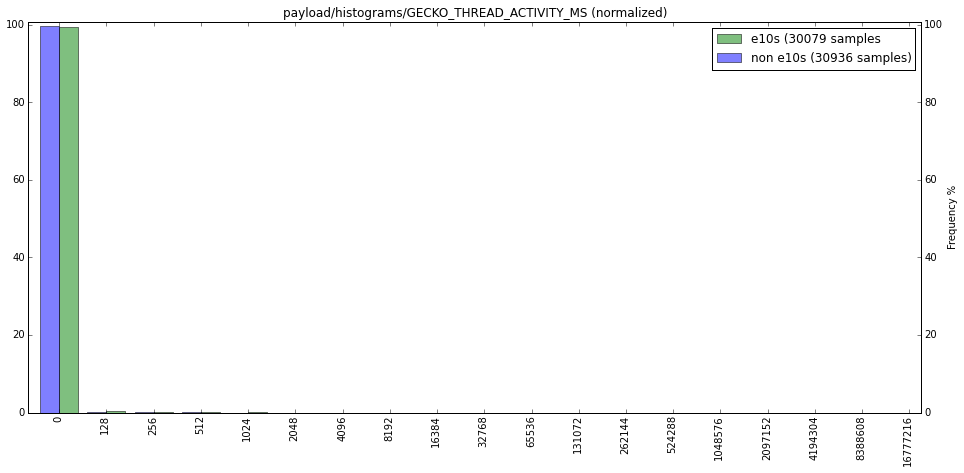

The probability that the distributions for payload/histograms/GECKO_THREAD_ACTIVITY_MS (normalized) are differing by chance is 0.00.


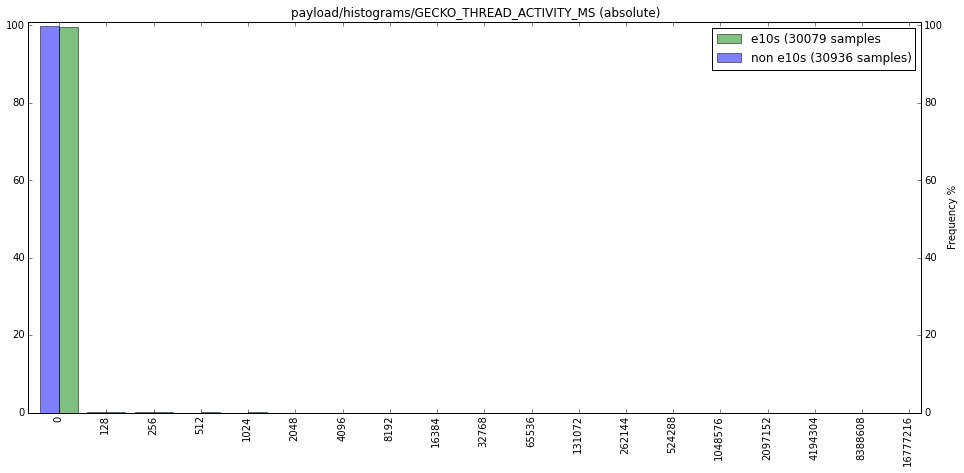

The probability that the distributions for payload/histograms/GECKO_THREAD_ACTIVITY_MS (absolute) are differing by chance is 0.00.


In [11]:
compare_thread_activity(subset, "Gecko", 0)

#### Parent main thread activity with sub-128ms buckets ignored completely

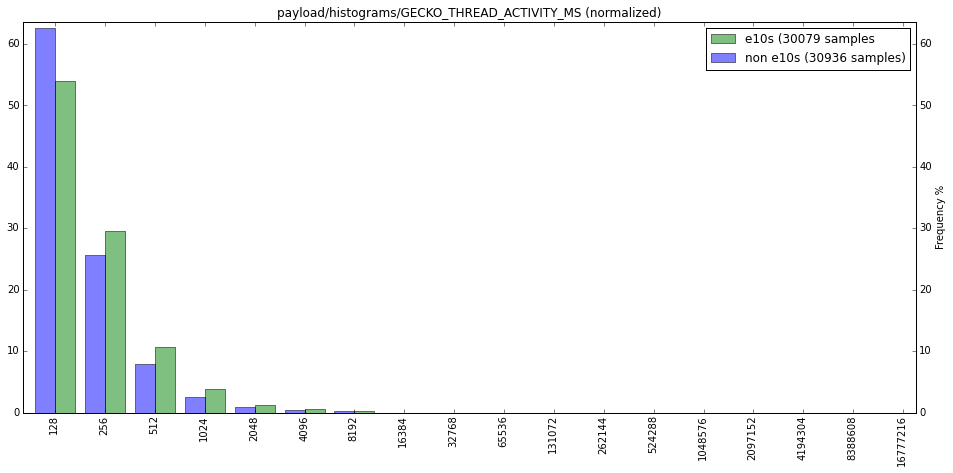

The probability that the distributions for payload/histograms/GECKO_THREAD_ACTIVITY_MS (normalized) are differing by chance is 0.00.


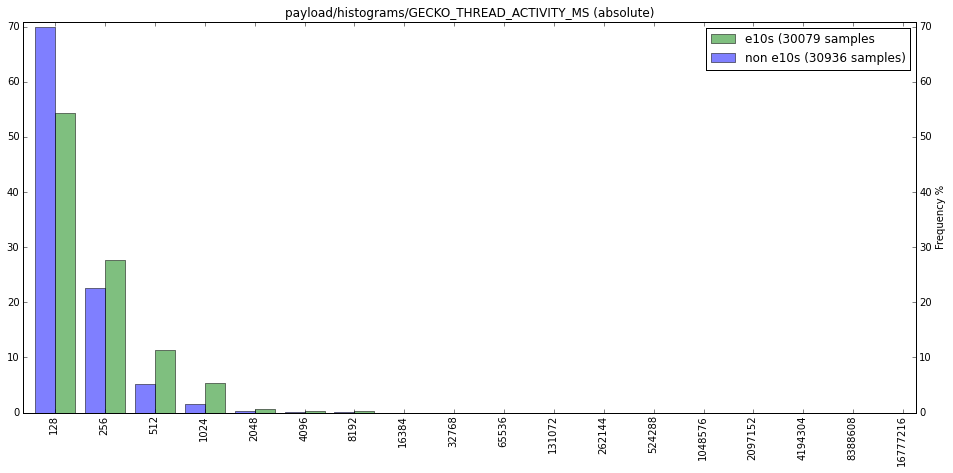

The probability that the distributions for payload/histograms/GECKO_THREAD_ACTIVITY_MS (absolute) are differing by chance is 0.00.


In [12]:
compare_thread_activity(subset, "Gecko", 128)

#### Get top stacks

In [13]:
def get_stacks(subset):
    def yield_ping_stacks(ping):
        for thread in ping["payload"]["threadHangStats"]:
            if thread["name"] != "Gecko":
                continue
            for hang in thread["hangs"]:
                if not hang["stack"]:
                    continue
                values = hang["histogram"]["values"]
                histogram = pd.Series(values.values(), index=map(int, values.keys())).sort_index()
                min_ms = 100
                over_min_ms_count = histogram[histogram.index > min_ms].sum()
                yield (tuple(hang["stack"]), over_min_ms_count)
    return subset.flatMap(yield_ping_stacks).reduceByKey(lambda a, b: a + b).collectAsMap()

In [14]:
we10s_stacks = get_stacks(subset.filter(lambda p: p["e10s"]))

In [15]:
ne10s_stacks = get_stacks(subset.filter(lambda p: not p["e10s"]))

In [16]:
def group_by_top_frame(stacks):
    total_hits = 0
    top_frames = {}
    for stack, hits in stacks.iteritems():
        stack_top_frame = stack[-1]
        if not stack_top_frame in top_frames:
            top_frames[stack_top_frame] = { "frame": stack_top_frame, "stacks": [], "hits": 0 }

        top_frame = top_frames[stack_top_frame]

        # Keep stacks sorted by hits.
        top_frame["stacks"].append((stack, hits))
        top_frame["stacks"].sort(key=lambda d: d[1], reverse=True)

        top_frame["hits"] += hits
        total_hits += hits

    return top_frames, total_hits

def get_stack_hits(stacks, stack):
    for s, h in stacks:
        if s == stack:
            return h
    return 0

In [17]:
we10s_groups, we10s_total_hits = group_by_top_frame(we10s_stacks)

In [18]:
ne10s_groups, ne10s_total_hits = group_by_top_frame(ne10s_stacks)

### Top stacks grouped by top frame

In [19]:
we10s_sorted_groups = sorted(we10s_groups.values(), key=lambda d: d["hits"], reverse=True)

def print_e10s_groups(group_count, stack_count):
    for we10s_group in we10s_sorted_groups[0:group_count]:
        ne10s_group = ne10s_groups.get(we10s_group["frame"], {})
        ne10s_stacks = ne10s_group.get("stacks", [])
        ne10s_hits = ne10s_group.get("hits", 0)

        print "{:.2f}% ({:.2f}%): {} ({})".format(
            100.0 * we10s_group["hits"] / we10s_total_hits,
            100.0 * ne10s_hits / ne10s_total_hits,
            we10s_group["frame"],
            we10s_groups["hits"])
        for we10s_stack, we10s_stack_hits in we10s_group["stacks"][0:stack_count]:
            ne10s_stack_hits = get_stack_hits(ne10s_stacks, we10s_stack)
            print "  - {:.4f}% ({:.4f}%):".format(
                100.0 * we10s_stack_hits / we10s_total_hits,
                100.0 * ne10s_stack_hits / ne10s_total_hits)
            print "    {}\n".format("\n    ".join(reversed(we10s_stack)))

#### Parent process top frames

The results are in the form: `e10s% (non-e10s%): top frame (total e10s hits)`

In [20]:
print_e10s_groups(25, 0)

47.20% (23.04%): Startup::XRE_Main (16701333)
15.56% (17.10%): Timer::Fire (5505676)
12.99% (0.00%): IPDL::PCookieService::RecvGetCookieString (4595635)
3.95% (0.01%): IPDL::PScreenManager::RecvScreenForBrowser (1396863)
3.21% (0.15%): nsHttpChannel::OnDataAvailable (1137112)
2.90% (4.88%): nsCycleCollector::forgetSkippable (1027088)
1.21% (0.15%): nsHttpChannel::OnStartRequest (427250)
0.93% (0.00%): IPDL::PHttpChannel::AsyncSendOnProgress (330764)
0.86% (0.00%): IPDL::PNecko::RecvPHttpChannelConstructor (305463)
0.70% (0.00%): IPDL::PBrowser::RecvAsyncMessage (247683)
0.68% (0.03%): nsInputStreamPump::OnStateTransfer (239824)
0.50% (0.00%): IPDL::PJavaScript::SendGet (176236)
0.44% (6.81%): js::GCRuntime::collect (154701)
0.42% (0.00%): IPDL::PCookieService::RecvSetCookieString (147245)
0.36% (0.19%): nsViewManager::DispatchEvent (128959)
0.31% (0.00%): IPDL::PContent::RecvScriptError (110099)
0.29% (0.72%): PresShell::Flush (103274)
0.27% (1.04%): nsCycleCollector::collectSlice (968

#### Parent process top stacks for top frames

In [21]:
print_e10s_groups(25, 3)

47.20% (23.04%): Startup::XRE_Main (16701333)
  - 47.1973% (23.0354%):
    Startup::XRE_Main

15.56% (17.10%): Timer::Fire (5505676)
  - 15.4949% (16.7587%):
    Timer::Fire
    Startup::XRE_Main

  - 0.0122% (0.1450%):
    Timer::Fire
    gre/components/nsPrompter.js:78
    app/components/nsBrowserGlue.js:1226
    Startup::XRE_Main

  - 0.0099% (0.0070%):
    Timer::Fire
    services-common/async.js:156
    gre/modules/services-sync/browserid_identity.js:693
    services-sync/resource.js:432
    gre/modules/services-sync/service.js:558
    services-sync/stages/enginesync.js:35
    gre/modules/services-sync/service.js:1302
    services-sync/util.js:146
    services-sync/util.js:98
    gre/modules/services-sync/service.js:1299
    gre/modules/services-sync/service.js:1279
    services-sync/util.js:76
    gre/modules/services-sync/service.js:1272
    Startup::XRE_Main

12.99% (0.00%): IPDL::PCookieService::RecvGetCookieString (4595635)
  - 12.9645% (0.0002%):
    IPDL::PCookieService::Re

### Top stacks

In [22]:
def print_top_stacks(a_stacks, b_stacks, count):
    from collections import Counter
    a_total_count = sum(a_stacks.values())
    b_total_count = sum(b_stacks.values())
    for a_stack, a_stack_count in Counter(a_stacks).most_common(count):
        b_stack_count = b_stacks.get(a_stack, 0)
        print "- {:.4f}% ({:.4f}%):".format(
            100.0 * a_stack_count / a_total_count,
            100.0 * b_stack_count / b_total_count)
        print "  {}\n".format("\n  ".join(reversed(a_stack)))

#### e10s parent process stacks

In [23]:
print_top_stacks(we10s_stacks, ne10s_stacks, 25)

- 47.1973% (23.0354%):
  Startup::XRE_Main

- 15.4949% (16.7587%):
  Timer::Fire
  Startup::XRE_Main

- 12.9645% (0.0002%):
  IPDL::PCookieService::RecvGetCookieString
  Startup::XRE_Main

- 3.9430% (0.0066%):
  IPDL::PScreenManager::RecvScreenForBrowser
  Startup::XRE_Main

- 3.2117% (0.1447%):
  nsHttpChannel::OnDataAvailable
  nsInputStreamPump::OnStateTransfer
  nsInputStreamPump::OnInputStreamReady
  Startup::XRE_Main

- 2.8906% (4.8032%):
  nsCycleCollector::forgetSkippable
  Timer::Fire
  Startup::XRE_Main

- 1.2048% (0.1424%):
  nsHttpChannel::OnStartRequest
  nsInputStreamPump::OnStateStart
  nsInputStreamPump::OnInputStreamReady
  Startup::XRE_Main

- 0.9281% (0.0000%):
  IPDL::PHttpChannel::AsyncSendOnProgress
  nsHttpChannel::OnDataAvailable
  nsInputStreamPump::OnStateTransfer
  nsInputStreamPump::OnInputStreamReady
  Startup::XRE_Main

- 0.8609% (0.0007%):
  IPDL::PNecko::RecvPHttpChannelConstructor
  Startup::XRE_Main

- 0.6989% (0.0000%):
  IPDL::PBrowser::RecvAsyncMess

#### non-e10s parent process stacks

In [24]:
print_top_stacks(ne10s_stacks, we10s_stacks, 25)

- 23.0354% (47.1973%):
  Startup::XRE_Main

- 16.7587% (15.4949%):
  Timer::Fire
  Startup::XRE_Main

- 7.6513% (0.0483%):
  (content script)
  Timer::Fire
  Startup::XRE_Main

- 4.8032% (2.8906%):
  nsCycleCollector::forgetSkippable
  Timer::Fire
  Startup::XRE_Main

- 3.4762% (0.3343%):
  js::GCRuntime::collect
  nsJSContext::GarbageCollectNow
  Timer::Fire
  Startup::XRE_Main

- 3.0751% (0.0053%):
  (content script)
  EventDispatcher::Dispatch
  Startup::XRE_Main

- 2.0817% (0.0258%):
  js::GCRuntime::collect
  nsRefreshDriver::Tick
  Startup::XRE_Main

- 1.3873% (0.0587%):
  IPDL::PLayerTransaction::SendUpdate
  ShadowLayerForwarder::EndTransaction
  nsDisplayList::PaintRoot
  nsLayoutUtils::PaintFrame
  PresShell::Paint
  nsRefreshDriver::Tick
  Startup::XRE_Main

- 1.3311% (0.0000%):
  (content script)
  EventDispatcher::Dispatch
  nsViewManager::DispatchEvent
  Startup::XRE_Main

- 1.0433% (0.0043%):
  (content script)
  nsJSUtils::EvaluateString
  Startup::XRE_Main

- 1.0089% (